## Sound source localization via multiarray DOA & NN

### Loading modules, make data classes

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
plt.rcParams["font.size"] = 18
!mkdir ./fig

import sys

try:
    import pickle
except ImportError:
    print('Module pickle not installed, installing now')
    !{sys.executable} -m pip install pickle
    import pickle
    
try:
    import torch
    from torch.utils.data import Dataset
except ImportError:
    print('Module torch not installed, installing now')
    !{sys.executable} -m pip install torch
    import torch
    from torch.utils.data import Dataset


mkdir: ./fig: File exists


### set up experiment, choose data

In [2]:
b_divide_by_z = True # [x,y]/z instead of [x,y,z] doa vectors
b_center_doa  = True # center doa measures by their means 
                     # has an effect, linear model does not have biases for each doa component
b_offset_xy   = False # set first calibration point as origin # should only change the output bias / r_0

# SEPT 29th
b_divide_by_z = True # [x,y]/z instead of [x,y,z] doa vectors
filepath = './data/29_Sep2021_allData.p'
out_dim = 3
# all
filter_array_idx = [] # indices of arrays to discard throughout experiment
points = [] # indices of points to use, if empty, use all 0-17

# only full data set for calibration of affine mapping
filter_array_idx = [1,2,7] # only keep 3,4,5,6
points = [1,2,3,4,5,6,7,8,9,10,12,13,16,17] # all points with full calibration measruemetns arrays 2345

# further reduce
points = [1,6,9]#[1,4,6,9]
filter_array_idx += []

#### dataloader etc

In [3]:
def get_measurement_array_from_dict(dd, extract_all = False, Narrays=7):
    sources = [key for key in dd.keys()]
    Nsources = len(sources)

    if extract_all: # extract all sources
        Nsamples, NXYZchannels = dd[sources[0]].shape
        ddarray = np.empty((Nsamples,Nsources*NXYZchannels))
        for ss,source in enumerate(sources):
            for ii,chan in enumerate(dd[source].keys()[1:]):
                ddarray[:,ss*NXYZchannels+ii] = dd[source][chan]
    else:
        # for each channel, pick the first not-completely-nan source
        def gen_chankey(ii,ss):
            return ['X_{:d}_{:d}'.format(ss,ii),
                    'Y_{:d}_{:d}'.format(ss,ii),
                    'Z_{:d}_{:d}'.format(ss,ii)]
        Nsamples = dd[sources[0]].shape[0]
        ddarray = np.empty((Nsamples,Narrays*3))
        for ii in range(Narrays): # for each array, array 0 is not valid
            chankey = gen_chankey(ii+1,0)
            init = True
            valid = not np.all(np.isnan(dd[sources[0]][chankey]))
            for ss in range(4): # traverse along sources
                chankey = gen_chankey(ii+1,ss)
                if ss == 0:
                    xyz = dd[sources[ss]][chankey].copy()
                else:
                    xyz[vcheck] = dd[sources[ss]][chankey][vcheck]
                vcheck = np.isnan(xyz)
                valid = not np.any(vcheck)
            ddarray[:,ii*3:ii*3+3] = xyz
            
    # set nans to zero
    ddarray = np.nan_to_num(ddarray) 
    # remove all points picked up by less than two arrays
    ddarray = ddarray[np.sum(np.abs(ddarray) > 0,axis=1) > 3] 
    # filter repetitions
    grad = np.hstack([np.ones(1), np.linalg.norm(np.diff(ddarray,axis=0), axis=1)])
    ddarray = ddarray[grad>0] 

    return ddarray.astype(np.float32)

def delft(x,f,t): 
    if f is None:
        return x[t:]
    elif t is None:
        return x[:f]
    else:
        return np.vstack([x[:f],x[t:]])

class MultiarrayDoaDataset(Dataset):
    def __init__(self, pickle_file, out_dim, filter_array_idx, points = []):
        self.pickle_file = pickle_file
        data = pickle.load(open(self.pickle_file,'rb'))
        self.out_dim = out_dim
        points = np.array(points,dtype=np.int)
        self.N_channels = 3
        
        if '29' in pickle_file: # loads all channels
            self.calib_keys = ['cp{:d}'.format(ii) for ii in range(11)]
            iin = 0.025
            r = 45/2*iin
            l = 3.07
            self.room = np.zeros((9,3))
            self.room[:,:2] = np.cumsum(np.array([ [-l/2-1.72,-r-1.065], [0,3.63], [1.38,0], [0,.32], [2.33,0], [0,-.6], [6.55-1.38-2.33,0], [0,-3.35], [-6.55,0] ]),axis=0)
            
            
            p0  = np.array([      0.00,     0.00, 0.74])
            p1  = np.array([      0.00, -r+5*iin, 0.74])
            p2  = np.array([ -29.5*iin, -r+5*iin, 0.74])
            p3  = np.array([ -49.5*iin, -r+5*iin, 0.74])
            p4  = np.array([-l/2+5*iin,     0.00, 0.74])
            p5  = np.array([ -49.5*iin,  r-5*iin, 0.74])
            p6  = np.array([ -29.5*iin,  r-5*iin, 0.74])
            p7  = np.array([      0.00,  r-5*iin, 0.74])
            p8  = np.array([ 29.75*iin,  r-5*iin, 0.74]) 
            p9  = np.array([ l/2-5*iin,     0.00, 0.74]) 
            p10 = np.array([ 30.75*iin, -r+5*iin, 0.74])
            plist = [p0,p1,p2,p3,p4,p5,p6,p7,p8,p9,p10]
            
            # include other calibration points
            self.calib_keys.append('ground')
            plist.append(self.room[5]+np.array([.3,0,0]))
            self.calib_keys.append('door')
            plist.append(self.room[0]+np.array([1.58,0,1.00]))
            self.calib_keys.append('window')
            plist.append(self.room[0]+np.array([0,0,1.07]))
            self.calib_keys.append('CL')
            plist.append(self.room[3]+np.array([11.25*iin,-14*iin,0]))
            self.calib_keys.append('CR')
            plist.append(self.room[4]+np.array([-11.25*iin,-14*iin,0]))
            self.calib_keys.append('ML')
            plist.append(p5+np.array([0,-14*iin,0]))
            self.calib_keys.append('MR')
            plist.append(p3+np.array([0,+14*iin,0]))
            
            self.calib_xy = np.vstack(plist).astype(np.float32)
            # offset for speaker size, acoustic center approx + 5cm above location
            self.calib_xy += np.array([0,0,.05])
            
            # self.arrays = [aa for aa in range(0,7)]
            # [self.arrays.remove(aa-1) for aa in filter_array_idx];
            self.arrays = np.arange(1,8-len(filter_array_idx))
            
            doalist = [get_measurement_array_from_dict(data[key]) for key in self.calib_keys]
            # truncate point measurements
            idx = self.calib_keys.index('cp0')
            doalist[idx] = delft(doalist[idx],2140,2200)
            doalist[idx] = delft(doalist[idx],1070,1090)
            doalist[idx] = delft(doalist[idx],0,20)
            idx = self.calib_keys.index('cp1')
            doalist[idx] = delft(doalist[idx],0,100)
            doalist[idx] = delft(doalist[idx],100,None)
            idx = self.calib_keys.index('cp2')
            doalist[idx] = delft(doalist[idx],0,100)
            doalist[idx] = delft(doalist[idx],-150,None)
            idx = self.calib_keys.index('cp3')
            doalist[idx] = delft(doalist[idx],0,100)
            idx = self.calib_keys.index('cp4')
            doalist[idx] = delft(doalist[idx],1050,1250)
            doalist[idx] = delft(doalist[idx],0,100)
            # doalist[idx] = delft(doalist[idx],100,None)
            idx = self.calib_keys.index('cp5')
            doalist[idx] = delft(doalist[idx],0,100)
            idx = self.calib_keys.index('cp6')
            doalist[idx] = delft(doalist[idx],-150,None)
            doalist[idx] = delft(doalist[idx],1080,1100)
            doalist[idx] = delft(doalist[idx],0,250)
            doalist[idx] = delft(doalist[idx],100,None)
            idx = self.calib_keys.index('cp7')
            doalist[idx] = delft(doalist[idx],-100,None)
            doalist[idx] = delft(doalist[idx],0,50)
            idx = self.calib_keys.index('cp8')
            doalist[idx] = delft(doalist[idx],0,20)
            doalist[idx] = delft(doalist[idx],-250,None)
            idx = self.calib_keys.index('cp9')
            doalist[idx] = delft(doalist[idx],100,None)
            idx = self.calib_keys.index('cp10')
            doalist[idx] = delft(doalist[idx],920,1020)
            doalist[idx] = delft(doalist[idx],-100,None)
            
            if 'door' in self.calib_keys: 
                idx = self.calib_keys.index('door')
                doalist[idx] = delft(doalist[idx],0,150)
                doalist[idx] = delft(doalist[idx],1400,None)
            if 'window' in self.calib_keys: 
                idx = self.calib_keys.index('window')
                doalist[idx] = delft(doalist[idx],0,300)
            if 'ground' in self.calib_keys: 
                idx = self.calib_keys.index('ground')
                doalist[idx] = delft(doalist[idx],0,1000)
            if 'CL' in self.calib_keys: 
                idx = self.calib_keys.index('CL')
                doalist[idx] = delft(doalist[idx],1050,1150)
                doalist[idx] = delft(doalist[idx],0,100)
                doalist[idx] = delft(doalist[idx],-200,None)
            if 'CR' in self.calib_keys: 
                idx = self.calib_keys.index('CR')
                doalist[idx] = delft(doalist[idx],0,300)
            if 'ML' in self.calib_keys: 
                idx = self.calib_keys.index('ML')
                doalist[idx] = delft(doalist[idx],480,620)
                doalist[idx] = delft(doalist[idx],0,200)
                doalist[idx] = delft(doalist[idx],-100,None)
            if 'MR' in self.calib_keys: 
                idx = self.calib_keys.index('MR')
                doalist[idx] = delft(doalist[idx],0,350)
            
        else:
            print('undefined init for specified file')
            return None
        self.calib_xy = self.calib_xy[:,:self.out_dim]
        
        if len(points):
            doalist=[doalist[pp] for pp in points]
            self.calib_xy=np.array([self.calib_xy[pp] for pp in points])
        self.N_points = len(doalist)
        self.calib_doa = np.vstack(doalist).astype(np.float32)
        self.calib_id = np.hstack([ii*np.ones(cpm.shape[0]) for ii,cpm in enumerate(doalist)]).astype(np.int)
        
        self.calib_xy_mean = np.mean(self.calib_xy,axis=0)
            
        # offset training data
        if b_offset_xy:
            self.calib_xy_offset = -plist[0]
            self.calib_xy += self.calib_xy_offset
        else:
            self.calib_xy_offset = np.zeros(self.out_dim,dtype=np.float32)
            
        # Drop arrays
        for fi in np.flip(np.sort(filter_array_idx))-1:
            #print(self.calib_doa.shape, fi, fi*3,fi*3+3)
            self.calib_doa = np.delete(self.calib_doa, range(fi*3,fi*3+3), 1)
        
        if b_divide_by_z:
            # [x/z, y/z] instead of [x,y,z] on a unit sphere
            self.N_channels = 2
            self.calib_doa = np.hstack([
                np.true_divide( self.calib_doa[:,3*ii:3*ii+2] , self.calib_doa[:,3*ii+2,np.newaxis] ,
                              where=(self.calib_doa[:,3*ii+2,np.newaxis] != 0) | (self.calib_doa[:,3*ii+2,np.newaxis] != np.nan) 
                              ) for ii in range(int(self.calib_doa.shape[1]/3)) ])
            self.calib_doa = np.nan_to_num(self.calib_doa, copy=False)
        self.N_arrays = int(self.calib_doa.shape[1]/self.N_channels)
        
        
        self.calib_doa_mean   = np.mean(self.calib_doa, axis=0)
        if b_center_doa: # offset DOA by -mean 
            self.calib_doa_offset = -self.calib_doa_mean
            self.calib_doa += self.calib_doa_offset
        else:
            self.calib_doa_offset = np.zeros(self.calib_doa.shape[1])
        
        # load clean DOA data from arrays [0,1,2,3,5]
        # self.test_data = data["active_L_table_slide_DOA"]
        # _matrix includes timestamp (first row) and array#4 (all_nans)
        # self.active_L_table_slide_matrix = data["active_L_table_slide_matrix"]
        
        
        #self.active_long_table_slide_DOA = data["active_long_table_slide_DOA"]
        #self.active_long_table_slide_matrix = data["active_long_table_slide_matrix"]
        
    def __len__(self):
        return len(self.calib_id)
    
    def xyi(self,idx):
        return self.calib_xy[idx] # only obtain 2D calibration coordinates
    
    def __getitem__(self,idx):
        return self.calib_doa[idx,:], self.xyi(self.calib_id[idx])

In [4]:
# TODO: random number generator, used to split training / validation data set (10/80)?
tag = filepath.split('/')[-1].split('.')[0]
from torch.utils.data import DataLoader

training_data    = MultiarrayDoaDataset(filepath, out_dim, filter_array_idx, points)
train_dataloader = DataLoader(training_data, batch_size = 5, shuffle = True)

#"one array can not localize 3d"
if out_dim > training_data.calib_doa.shape[1]:
    out_dim = np.min([out_dim,training_data.calib_doa.shape[1]]) 
    print("underdetermined problem, fewer ins than outs. reduce outs")

# training_test = MultiarrayDoaDataset(filepath, out_dim, filter_array_idx, points)
# traintest_dataloader = DataLoader(training_test, batch_size = 5, shuffle = True)

mean 3.5762786e-09
min -0.7712238
max 0.6227579
sshape (300, 8)


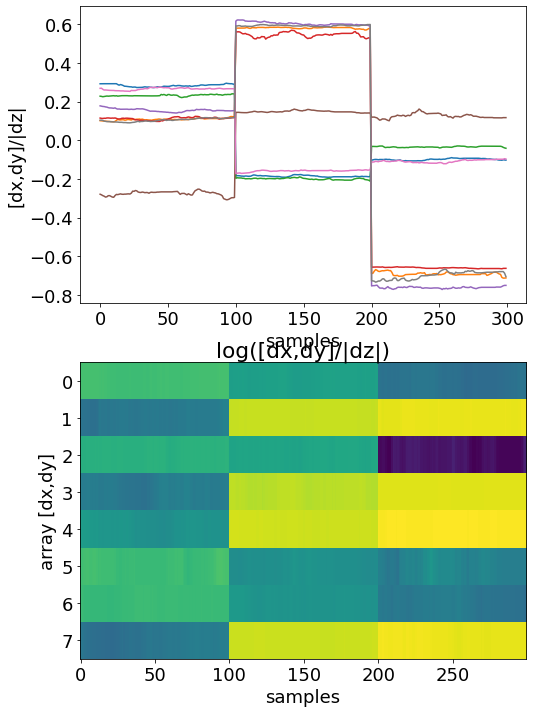

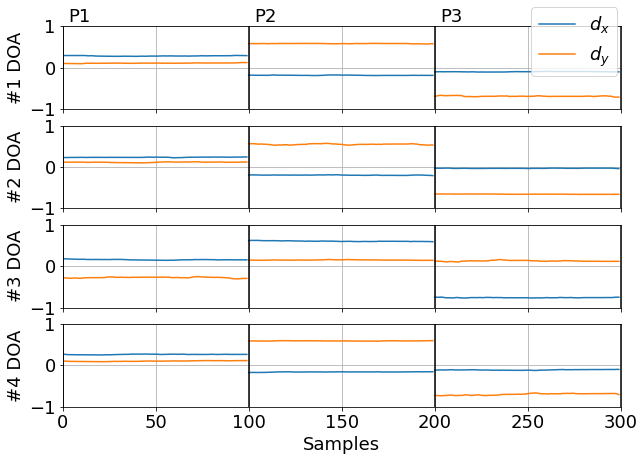

In [5]:
# inspect training data
print("mean", np.nanmean(training_data.calib_doa))
print("min", np.nanmin(training_data.calib_doa))
print("max", np.nanmax(training_data.calib_doa))
print("sshape", training_data.calib_doa.shape)

n0,n1 = 0,None
import matplotlib.pyplot as plt
plt.figure(1, figsize=(8,12))
plt.clf()
plt.subplot(211)
plt.plot(training_data.calib_doa[n0:n1])
plt.ylabel('[dx,dy]/|dz|')
plt.xlabel('samples')
plt.subplot(212)
plt.imshow(np.log(np.abs(training_data.calib_doa[n0:n1])).T, interpolation='none')
plt.title('log([dx,dy]/|dz|)')
plt.ylabel('array [dx,dy]')
plt.xlabel('samples')
plt.gca().set_aspect('auto')
plt.savefig('./fig/'+tag+'_calib_data.png',bbox_inches='tight', pad_inches=0)
plt.show()

plt.figure(figsize=(10,7))
training_labels = ["P1","P2","P3"]
numplots = 4 # arrays
for jj in range(numplots):
    ax = plt.subplot(numplots,1,jj+1)
    oold = [0]
    for tmp in [
        training_data.calib_doa[  :100],
        training_data.calib_doa[100:200],
        training_data.calib_doa[200:],
    ]:
        oold.append(oold[-1]+len(tmp))
        if oold[-2] == 0:
            ax.plot(np.arange(oold[-2],oold[-1]),tmp[:,2*jj],label='$d_x$')
            ax.plot(np.arange(oold[-2],oold[-1]),tmp[:,2*jj+1],label='$d_y$')
        else:
            ax.plot(np.arange(oold[-2],oold[-1]),tmp[:,2*jj]  ,'C0')
            ax.plot(np.arange(oold[-2],oold[-1]),tmp[:,2*jj+1],'C1')
    [ax.axvline(oo,c='k') for oo in oold]
    plt.xlim([oold[0],oold[-1]])
    if ax.get_ylim()[0]>-1: ax.set_ylim([-1,ax.get_ylim()[1]])
    if ax.get_ylim()[0]< 1: ax.set_ylim([ax.get_ylim()[0],1])
    ax.set_ylabel("#{} DOA".format(training_data.arrays[jj]),x=-2.20)
    ax.set_xticks(np.arange(oold[0],oold[-1],1000), minor=True)
    ax.set_xticks(np.arange(oold[0],oold[-1],500), minor=True)
    plt.grid(True,which='both')
    if jj == 0:
        [ax.annotate(training_labels[ii],(oo/oold[-1]+.01,1.05),xycoords='axes fraction') 
             for ii,oo in enumerate(oold[:-1])]
        plt.legend(ncol=1,loc='upper right',bbox_to_anchor = (1.01,1.34))
    if jj+1<numplots: ax.set_xticklabels([])
    else: ax.set_xlabel('Samples')
plt.savefig('./fig/'+tag+'_training_data.pdf',bbox_inches='tight', pad_inches=0)

In [6]:
def get_test_data(filepath,out_dim,remove_array_idx=[],test_keys=None,doa_offset=0):# load and format test data
    data = pickle.load(open(filepath,'rb'))
    test_cases = list()
    
    if test_keys is None:
        test_keys =  [
            # included
            'rectangle', 
            'inner', 
            'counter', #trace

            # cleaned but not included
            # ground', # point, z = floor
            # window', #point
            # door', # point
            # outer', 
            # table1', # smooth
            #'MR', # suspect monitor points
            #'ML', 

            # neither clean nor included
            # 'table4', 'table2', 'table3',  'table5',  'table6', # disturbed
            # 'TR', 'TL', 'L2R', 'R2L', 
            # 'CL', 'CR', 'cR2L', 'cL2R',  
        ]
    for key in test_keys:
        test_data = get_measurement_array_from_dict(data[key]).astype(np.float32)

        # trim/clean specific point measurements
        if key == 'inner': 
            idx = test_keys.index(key)
            test_data = delft(test_data,988,990)
            test_data = delft(test_data,0,50)
        if key == 'door': 
            idx = test_keys.index(key)
            test_data = delft(test_data,0,150)
            test_data = delft(test_data,1400,None)
        if key == 'window': 
            idx = test_keys.index(key)
            test_data = delft(test_data,0,300)
        if key == 'ground': 
            idx = test_keys.index(key)
            test_data = delft(test_data,0,1000)
        if key == 'ML': 
            idx = test_keys.index(key)
            test_data = delft(test_data,480,620)
            test_data = delft(test_data,-200,None)
            test_data = delft(test_data,0,200)
        if key == 'MR': 
            idx = test_keys.index(key)
            test_data = delft(test_data,0,350)
        if key == 'table1': 
            idx = test_keys.index(key)
            test_data = delft(test_data,0,180)
            test_data = delft(test_data,1540,None)

        # replace labels
        test_labels = test_keys.copy()
        test_labels[test_labels.index('inner')]='screen'

        for fi in np.flip(np.sort(remove_array_idx))-1:
                test_data = np.delete(test_data,range(3*fi,3*fi+3),1)
        if b_divide_by_z:
            test_data = np.hstack([
                test_data[:,3*ii:3*ii+2] / test_data[:,3*ii+2,np.newaxis] 
                for ii in range(int(test_data.shape[1]/3))])
            np.nan_to_num(test_data, copy=False)

        test_data += doa_offset # iff offset in training data, apply here too
        test_data = torch.from_numpy(test_data.astype(np.float32))
        test_cases.append(test_data)
        
    return test_cases, test_labels

test_cases, test_labels = get_test_data(filepath,out_dim,remove_array_idx=filter_array_idx,doa_offset=training_data.calib_doa_offset)

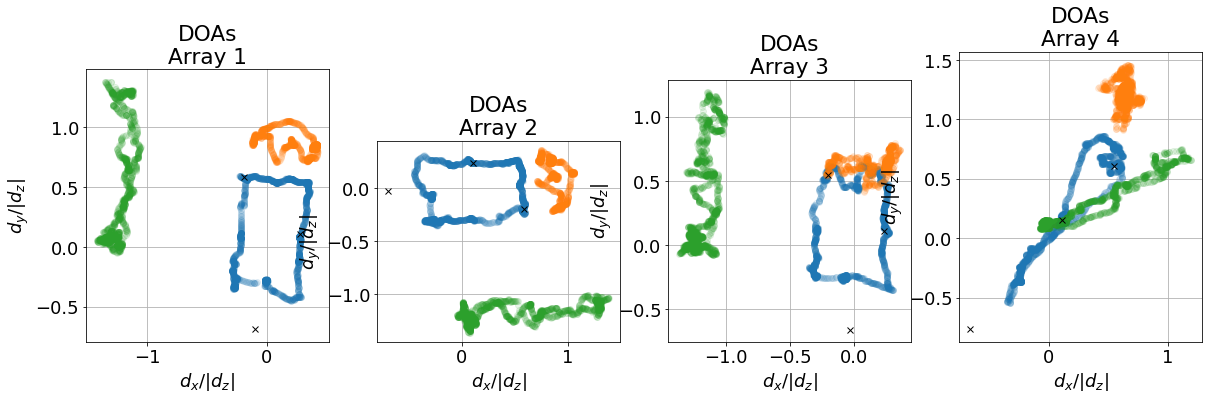

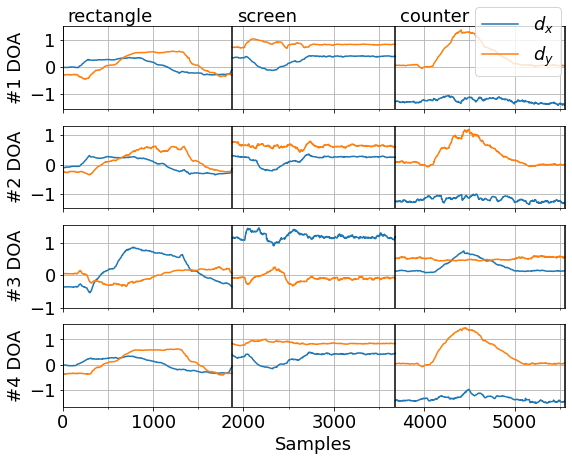

In [7]:
# inspect calibration points vs training or test data series
# tmp = test_all[n0:n1,:]
# tmp = training_data.calib_doa

Na = training_data.N_arrays
numplots = np.min([7,Na])

plt.figure(figsize=(20,8))
cpointdata = 1/np.array([
    np.nanmean(1/training_data.calib_doa[training_data.calib_id == ii],axis=0) 
    for ii in range(training_data.N_points)])
jj = 0
for ii in range(numplots):
    ax = plt.subplot(1,numplots,ii+1)
    while (np.all(np.isnan(cpointdata[:,jj])) | np.all(cpointdata[:,jj]==0)): jj+=1
    for tmp in test_cases:
        ax.plot(tmp[:,jj],tmp[:,jj+1],'o',alpha=.1)
    ax.plot(cpointdata[:,jj],cpointdata[:,jj+1],'kx')
    ax.set_title("DOAs\nArray {}".format(training_data.arrays[jj]))
    ax.set_xlabel('$d_x/|d_z|$')
    ax.set_ylabel('$d_y/|d_z|$')
    ax.set_aspect('equal')
    ax.set_anchor('SW')
    plt.grid()
    jj +=1

plt.figure(figsize=(9,7))
for jj in range(numplots):
    ax = plt.subplot(numplots,1,jj+1)
    oold = [0]
    for tmp in test_cases:
        oold.append(oold[-1]+len(tmp))
        if oold[-2] == 0:
            ax.plot(np.arange(oold[-2],oold[-1]),tmp[:,2*jj],label='$d_x$')
            ax.plot(np.arange(oold[-2],oold[-1]),tmp[:,2*jj+1],label='$d_y$')
        else:
            ax.plot(np.arange(oold[-2],oold[-1]),tmp[:,2*jj]  ,'C0')
            ax.plot(np.arange(oold[-2],oold[-1]),tmp[:,2*jj+1],'C1')
    [ax.axvline(oo,c='k') for oo in oold]
    plt.xlim([oold[0],oold[-1]])
    if ax.get_ylim()[0]>-1:
        ax.set_ylim([-1,ax.get_ylim()[1]])
    ax.set_ylabel("#{} DOA".format(training_data.arrays[jj]),x=-2.20)
    #ax.set_xticks(oold+[1000,3000,4500],minor=False)
    ax.set_xticks(np.arange(oold[0],oold[-1],1000), minor=True)
    ax.set_xticks(np.arange(oold[0],oold[-1],500), minor=True)
    plt.grid(True,which='both')
    if jj == 0:
        [ax.annotate(test_labels[ii],(oo/oold[-1]+.01,1.05),xycoords='axes fraction') 
             for ii,oo in enumerate(oold[:-1])]
        plt.legend(ncol=1,loc='upper right',bbox_to_anchor = (1.01,1.34))
    if jj+1<numplots: ax.set_xticklabels([])
    else: ax.set_xlabel('Samples')
plt.savefig('./fig/'+tag+'_test_data.pdf',bbox_inches='tight', pad_inches=0)
    
plt.show()

In [8]:
def show_localization(pred, color=None,label=None, r0 = None,axes=None,ylims=None,xlims=None):
    lopts = {'bbox_to_anchor':(.4,1),'loc':'lower center'}
    if ylims: 
        fsize = (6,6)
        topts = {'fontsize':18}
        opts = {'ms':1}
        lopts.update({'markerscale':20})
    else: 
        lopts.update({'markerscale':4})
        fsize = (6,6)
        topts = {}
        opts = {'ms':5}
    if axes == None:
        fig = plt.figure(figsize=fsize)
        # axes = [plt.subplot(121), plt.subplot(122)]
        axes = [plt.subplot(111)]
        
    offset = training_data.calib_xy_offset[:2]
    pargs = {'color': '#cccccc','zorder':1,'alpha':1.0}
    if 'Sep' in filepath:
        d = 1.185
        r = d/2
        l = 3.07
        room = training_data.room[:,:2]
        axes[0].plot(room[:,0],room[:,1],'k',lw=3)
        alpha = np.linspace(np.pi,3/2*np.pi,100)
        cake = np.array([np.cos(alpha), np.sin(alpha)]).T
        door = room[6] + np.array([[-.2,0]]) + np.vstack([[0,0], cake,[0,0]])
        axes[0].plot(door[:,0],door[:,1],'k',alpha=.5)
        furniture = [
            mpl.patches.Rectangle(tuple(room[3]-[0,.6]),2.33,.6, **pargs), # counter
            mpl.patches.Rectangle((-1.535+r,-r),3.07-d,d, **pargs), # table
            mpl.patches.Ellipse(  (-1.535+r,0),d,d,**pargs),
            mpl.patches.Ellipse(  ( 1.535-r,0),d,d,**pargs),
        ]
        screen_center = np.array([-l/2+5*.025,     0.00])

        axes[0].plot(screen_center[0]+[14*.025,14*.025],screen_center[1]+[-.30,.30],'k',alpha=.8,lw=3,zorder=2)
        [axes[0].add_patch(ff) for ff in furniture]
        
        iin = .025
        p0  = np.array([      0.00,     0.00, 0.74])
        p1  = np.array([      0.00, -r+5*iin, 0.74])
        p2  = np.array([ -29.5*iin, -r+5*iin, 0.74])
        p3  = np.array([ -49.5*iin, -r+5*iin, 0.74])
        p4  = np.array([-l/2+5*iin,     0.00, 0.74])
        p5  = np.array([ -49.5*iin,  r-5*iin, 0.74])
        p6  = np.array([ -29.5*iin,  r-5*iin, 0.74])
        p7  = np.array([      0.00,  r-5*iin, 0.74])
        p8  = np.array([ 29.75*iin,  r-5*iin, 0.74]) 
        p9  = np.array([ l/2-5*iin,     0.00, 0.74]) 
        p10 = np.array([ 30.75*iin, -r+5*iin, 0.74])
        plist = np.array([p2,p6,p8,p10,p2])
        axes[0].plot(plist[:,0],plist[:,1],'--k',alpha=.4,linewidth=2)
        alpha = np.linspace(3/2*np.pi,1/2*np.pi,100)
        angle = np.array([np.cos(alpha), np.sin(alpha)])
        radius= (r-5**iin)*(2+np.cos(alpha))/2
        cake = -angle*radius
        plist = (p3+(p5-p3)/2)[:2] +np.vstack([[0,0], cake.T,[0,0]])
        axes[0].plot(plist[:,0],plist[:,1],'--k',alpha=.4,linewidth=2)
        cl = training_data.room[3]+np.array([11.25*iin,-14*iin,0])
        cr = training_data.room[4]+np.array([-11.25*iin,-14*iin,0])
        off1 = np.array([-2*iin,-2*iin,0])
        off2 = np.array([-2*iin, 2*iin,0])
        plist = np.array([cl+off1,cl+off2,cr-off1,cr-off2,cl+off1])
        axes[0].plot(plist[:,0],plist[:,1],'--k',alpha=.4,linewidth=2)

    if len(pred)==4: lopts.update({'ncol':2})
    else:       lopts.update({'ncol':3})
    if type(pred) is list:
        for tt,pp in enumerate(pred):
            
            if color is None:  opts.update({'c':'C{:d}'.format(tt)})
            else:              opts.update({'c':color})
            
            if type(label) is list: opts.update({'label':label[tt]});
            elif 'fit' in label:    opts.update({'label':'P{:d}'.format(tt)}); lopts.update({'ncol':4});
            else:                   opts.update({'label':test_labels[tt]})
            
            axes[0].plot(pp[:,0],pp[:,1],'.',**opts)
            
            # xline = axes[1].plot(pp[:,0],**opts)
            # axes[1].plot(pp[:,1],c = xline[0].get_color())
            # if pp.shape[1]>2: 
            #     axes[1].plot(pp[:,2],c=xline[0].get_color())
    else:
        axes[0].plot(pred[:,0],pred[:,1],color=color,label=label)
        taglist = ['x','y','z']
        # for ii,pp in enumerate(pred.T):
        #     axes[1].plot(pp,label='{} [m]'.format(taglist[ii]))
        
    axes[0].scatter(training_data.calib_xy[:,0],training_data.calib_xy[:,1],  c='k', s=30, zorder=2)
    #[ axes[0].scatter(td[0],td[1], alpha=.5, s=30, label=ii) for ii,td in enumerate(training_data.calib_xy)]
    if np.any(r0):
        axes[0].plot(r0[0],r0[1], 'kx', label='$r_0$ / bias')
    axes[0].set_xlabel("x [m]",**topts)
    axes[0].set_ylabel("y [m]",**topts)
    axes[0].set_aspect('equal')
    axes[0].set_anchor('SW')
    # for kk in range(training_data.calib_xy.shape[0]):
      # axes[0].scatter(training_data.calib_xy[kk,0]+0.2, 
                    # training_data.calib_xy[kk,1], 
                    # marker="${:d}$".format(kk+1), s=90, c='k')
    xt = np.arange(*np.ceil(axes[0].get_xlim())*2)/2
    yt = np.arange(*np.ceil(axes[0].get_ylim())*2)/2
    axes[0].set_xticks(xt,minor=True)
    axes[0].set_yticks(yt,minor=True)
    xt = np.arange(*np.ceil(axes[0].get_xlim()))
    yt = np.arange(*np.ceil(axes[0].get_ylim()))
    axes[0].set_xticks(xt,minor=False)
    axes[0].set_yticks(yt,minor=False)
    axes[0].grid(True,which='both')
    if ylims: axes[0].set_ylim(ylims)
    if xlims: axes[0].set_xlim(xlims)
    
    # axes[1].set_xlabel('snapshot')
    # axes[1].grid()
    
    lopts.update({'ncol':1,'loc':'upper right','bbox_to_anchor':(1.02,1.),'handletextpad':.1})
    
    axes[0].legend(**lopts,**topts)
    
    # axes[1].legend(ncol=1)
    # axes[1].set_ylabel('x/y/z [m]')
    return axes

## LA model

In [9]:
# B, R_mean, D_mean,D = generate_linear_transform_matrix(data['cp_list'], training_data.calib_xy, training_data.out_dim) 
def generate_linear_transform_matrix(D, R, rcond=None, trunc=None):
    # cdoa: list of DOA arrays for each point
    # coordinates for each point
    # optional:
        # trunc: -> number of PCA components to be considered
        # rcond: float within 0..1 -> limit below which normalized singular values are truncated
    
    # B
    R_mean = np.mean(R, axis=1).reshape(-1,1)
    D_mean = np.mean(D, axis=1).reshape(-1,1)
    
    # calculating moore penrose inverse
    # via SVD
    ### assembled D = (U@np.diag(sigma))@VH[:len(sigma)]
    ### truncated D = (U[:,;trunc]@np.diag(sigma[:trunc]))@VH[:trunc]
    ### MP inv    D = (VH[:trunc].T@np.diag(1/sigma[:trunc]))@U.T[:trunc]
    
    U,sigma,VH = np.linalg.svd(D-D_mean)
    sscaled = sigma/sigma[0]
    print('D-Dmean\n - singular values (scaled):',sscaled, '\n - condition number:',sigma[0]/sigma[-1])
    if not trunc:
        if rcond:
            trunc = np.argwhere(sscaled<rcond)[0]
            print(' - kept singular values' , sscaled[:trunc], '\n - new condition number:',sigma[0]/sigma[trunc-1])
        else:
            print(' - keep all singular values, no truncation')
            
    if trunc:
        D_inv = (VH[:trunc].T@np.diag(1/sigma[:trunc]))@U.T[:trunc]
    else:
        D_inv = (VH[:len(sigma)].T@np.diag(1/sigma))@U.T
    
    ### via rcond directly 
    # if not rcond: 
    #     if trunc:
    #         rcond = sscaled[trunc-1]*.99
    #     else:
    #         rcond = 1e-3 # as good as full
    # D_inv = np.linalg.pinv(D-D_mean, rcond = rcond) 
    
    # obtaining linear transformation matrix
    B = (R - R_mean) @ D_inv 
    R_0 = R_mean - B @ D_mean
    return B, R_0, U, sigma , VH

# SETTING MACROS
LM_TRUNC = out_dim # automatically adjusted to 2 for one array
# LM_TRUNC = None # NO TRUNCATION
# LM_TRUNC = 2 # 2D localization only

D-Dmean
 - singular values (scaled): [1.         0.35800442 0.01169011 0.00766234 0.00693385 0.00643199
 0.00493249 0.00284256] 
 - condition number: 351.79532
MSE training:  8.444315443436305e-05


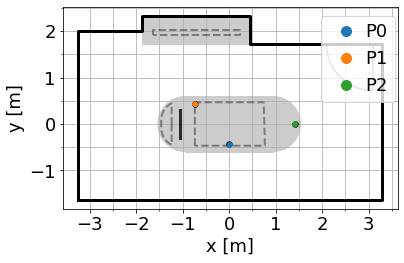

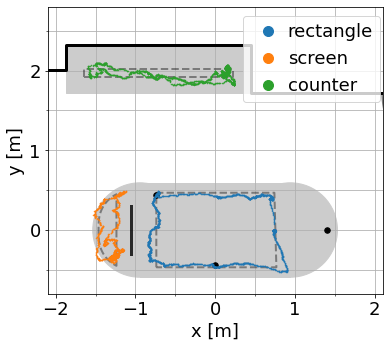

In [10]:
## LINEAR MAPPING FULL CASE
#rcond = .01 # truncate singular vectors < .01 (normalized by maximum)

B, R_0, U,sigma ,VH = generate_linear_transform_matrix(
    training_data.calib_doa.T, 
    training_data.calib_xy[training_data.calib_id].T, 
    trunc = LM_TRUNC)

affine_predict = lambda doa: (R_0 + B @ doa.T).T

# Analyze fit
fit = [affine_predict(training_data.calib_doa[training_data.calib_id==ii]) for ii in np.unique(training_data.calib_id)]
reference = training_data.calib_xy[training_data.calib_id]
print("MSE training: ", np.sum((np.vstack(fit)-reference)**2)/len(reference))
show_localization(fit, label = 'affine mapping fit\nSVD truncated at {:.2f}'.format(LM_TRUNC))
plt.savefig('./fig/'+tag+'_0_affine_reference_calib.pdf',bbox_inches='tight',pad_inches=0)

# predict test data localizations
predictions = [affine_predict(td.numpy()) for td in test_cases]
opts = {'ylims':[-.8,2.8],'xlims':[-2.1,2.1]}
show_localization(predictions, label= 'affine mapping prediction\nSVD truncated at {:.2f}'.format(LM_TRUNC),**opts)
plt.savefig('./fig/'+tag+'_0_affine_reference.pdf',bbox_inches='tight', pad_inches=0)
plt.show()

In [11]:
## LINEAR MAPPING DEMO CASE FOR ARRAY SUBSETS
def run_test(deactivate_arrays_sequence, trunc = LM_TRUNC): # run test with affine mapping from array subset. input list of 3,4,5,6 to choose which arrays to drop
    predictions = list()
    for jj,deactivate in enumerate(deactivate_arrays_sequence):
        
        # SEPT 29th
        b_divide_by_z = True # [x,y]/z instead of [x,y,z] doa vectors
        filepath = './data/29_Sep2021_allData.p'
        out_dim = 3

        # only full data set for calibration of affine mapping
        filter_array_idx = [1,2,7] # only keep 3,4,5,6
        points = [1,2,3,4,5,6,7,8,9,10] # all points with full calibration measruemetns arrays 3456

        # further reduce
        #points = [1,4,6,9]
        filter_array_idx += [dd+2 for dd in deactivate] # offset to start at 3...
        training_data    = MultiarrayDoaDataset(filepath, out_dim, filter_array_idx, points)
        print(filter_array_idx, training_data.arrays)

        train_dataloader = DataLoader(training_data, batch_size = 5, shuffle = True)
        #"one array can not localize 3d"
        if trunc is not None and trunc > training_data.calib_doa.shape[1]:
            trunc = np.min([trunc,training_data.calib_doa.shape[1]]) 
            print("underdetermined problem, fewer ins than outs. reduce outs")

        test_keys =  [ 'rectangle',  'inner',  'counter', ]
        test_cases,_ = get_test_data(filepath,out_dim, test_keys=test_keys, 
                                   remove_array_idx = filter_array_idx, doa_offset=training_data.calib_doa_offset)

        B, R_0, U,sigma ,VH = generate_linear_transform_matrix(
            training_data.calib_doa.T, 
            training_data.calib_xy[training_data.calib_id].T, 
            trunc = trunc) 
        affine_predict = lambda doa: (R_0 + B @ doa.T).T

        # Analyze fit
        fit = [affine_predict(training_data.calib_doa[training_data.calib_id==ii]) for ii in np.unique(training_data.calib_id)]
        reference = training_data.calib_xy[training_data.calib_id]
        print("MSE training: ", np.sum((np.vstack(fit)-reference)**2)/len(reference))
        #show_localization(fit, 'C{:d}'.format(jj), 'affine mapping fit\nSVD truncated at {:.2f}'.format(rcond), r0=R_0)
        #plt.savefig('./fig/'+tag+'_0_affine_reference_calib.pdf',bbox_inches='tight',pad_inches=0)

        # predict test data localizations
        predictions.append(np.vstack([affine_predict(td.numpy()) for td in test_cases]))

        # predictions = [affine_predict(td.numpy()) for td in test_cases]
        # opts = {'color':'C{:d}'.format(jj), 'label':'affine mapping prediction\nSVD truncated at {:.2f}'.format(rcond), 'r0':R_0}
        # if jj == 0: axes = show_localization(predictions, **opts)
        # else: axes = show_localization(predictions,axes=axes, **opts)
    return predictions

def list_diff(list1, list2): 
    return (list(set(list1) - set(list2)))

In [12]:
# Subsets of three arrays
sequence3 = [[4],[3],[2],[1]]
predictions3 = run_test(sequence3)

[1, 2, 7, 6] [1 2 3]
D-Dmean
 - singular values (scaled): [1.         0.3837362  0.09491338 0.05802798 0.04066397 0.01405519] 
 - condition number: 71.14808
MSE training:  0.00457037391414601
[1, 2, 7, 5] [1 2 3]
D-Dmean
 - singular values (scaled): [1.         0.46217334 0.05064685 0.02893899 0.0254804  0.01603334] 
 - condition number: 62.370026
MSE training:  0.003983006872401911
[1, 2, 7, 4] [1 2 3]
D-Dmean
 - singular values (scaled): [1.         0.36030635 0.10057188 0.04687829 0.02214505 0.01339008] 
 - condition number: 74.68215
MSE training:  0.003908059739692943
[1, 2, 7, 3] [1 2 3]
D-Dmean
 - singular values (scaled): [1.         0.37523514 0.10460942 0.05687794 0.040616   0.01570835] 
 - condition number: 63.6604
MSE training:  0.00556050723623208


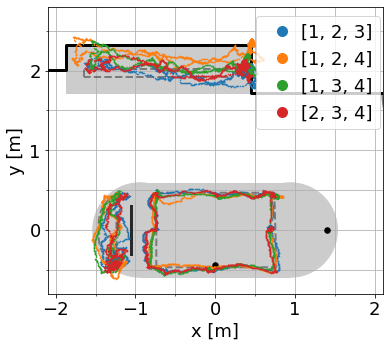

In [13]:
narrays = 4-len(sequence3[0])
opts = {'label':[str(list_diff([1,2,3,4],ss)) for ss in sequence3], 'ylims':[-.8,2.8],'xlims':[-2.1,2.1]}
show_localization(predictions3, **opts)
plt.savefig('./fig/'+tag+'_0_affine_{}oo4.pdf'.format(narrays),bbox_inches='tight', pad_inches=0)
plt.show()

In [14]:
# subsets of two arrays
sequence2 = [[3,4],[2,4],[2,3],[1,4],[1,3],[1,2]]
predictions2 = run_test(sequence2)

[1, 2, 7, 5, 6] [1 2]
D-Dmean
 - singular values (scaled): [1.         0.49128827 0.06077396 0.02892007] 
 - condition number: 34.578056
MSE training:  0.0032644015905320158
[1, 2, 7, 4, 6] [1 2]
D-Dmean
 - singular values (scaled): [1.        0.334545  0.0880556 0.0514175] 
 - condition number: 19.448633
MSE training:  0.004875127147249151
[1, 2, 7, 4, 5] [1 2]
D-Dmean
 - singular values (scaled): [1.         0.43208915 0.03321323 0.02137373] 
 - condition number: 46.786396
MSE training:  0.00344139648529068
[1, 2, 7, 3, 6] [1 2]
D-Dmean
 - singular values (scaled): [1.         0.35344785 0.0952251  0.06730662] 
 - condition number: 14.857381
MSE training:  0.01109509055545716
[1, 2, 7, 3, 5] [1 2]
D-Dmean
 - singular values (scaled): [1.         0.46906632 0.05811654 0.03044573] 
 - condition number: 32.845325
MSE training:  0.0068518194601443995
[1, 2, 7, 3, 4] [1 2]
D-Dmean
 - singular values (scaled): [1.         0.32524633 0.10545719 0.04870402] 
 - condition number: 20.532185
MS

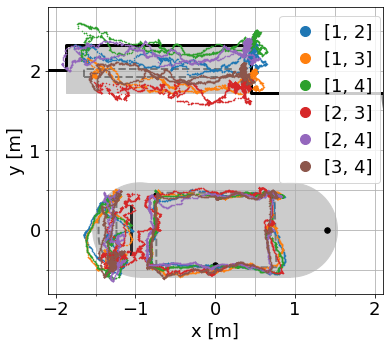

In [15]:
narrays = 4-len(sequence2[0])
opts = {'label':[str(list_diff([1,2,3,4],ss)) for ss in sequence2], 'ylims':[-.8,2.8],'xlims':[-2.1,2.1]}
show_localization(predictions2, **opts)
plt.savefig('./fig/'+tag+'_0_affine_{}oo4.pdf'.format(narrays),bbox_inches='tight', pad_inches=0)
plt.show()

In [16]:
# Single array
sequence1 = [[2,3,4],[1,3,4],[1,2,4],[1,2,3]]
predictions1 = run_test(sequence1)

[1, 2, 7, 4, 5, 6] [1]
underdetermined problem, fewer ins than outs. reduce outs
D-Dmean
 - singular values (scaled): [1.         0.44941536] 
 - condition number: 2.2251132
MSE training:  0.002775218650129839
[1, 2, 7, 3, 5, 6] [1]
D-Dmean
 - singular values (scaled): [1.        0.5474153] 
 - condition number: 1.8267665
MSE training:  0.01699957169578719
[1, 2, 7, 3, 4, 6] [1]
D-Dmean
 - singular values (scaled): [1.        0.2563145] 
 - condition number: 3.901457
MSE training:  0.0406769556807645
[1, 2, 7, 3, 4, 5] [1]
D-Dmean
 - singular values (scaled): [1.         0.41641667] 
 - condition number: 2.4014409
MSE training:  0.007637048089557895


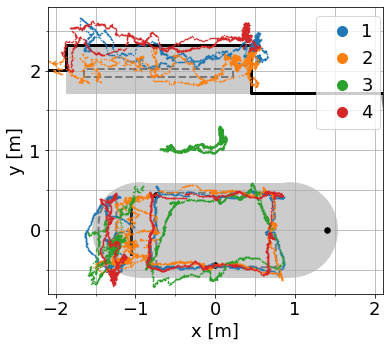

In [17]:
narrays = 4-len(sequence1[0])
opts = {'label':[str(list_diff([1,2,3,4],ss)[0]) for ss in sequence1], 'ylims':[-.8,2.8],'xlims':[-2.1,2.1]}
show_localization(predictions1, **opts)
plt.savefig('./fig/'+tag+'_0_affine_{}oo4.pdf'.format(narrays),bbox_inches='tight', pad_inches=0)
plt.show()

In [18]:
# Three array subset example with different regularization (PCA truncation J)
Nexamples = 1
J = [None, 3,2]
pp=list()
for jj in J:
    pp += run_test(sequence3[:Nexamples],trunc=jj)

[1, 2, 7, 6] [1 2 3]
D-Dmean
 - singular values (scaled): [1.         0.3837362  0.09491338 0.05802798 0.04066397 0.01405519] 
 - condition number: 71.14808
 - keep all singular values, no truncation
MSE training:  0.0013781829086179076
[1, 2, 7, 6] [1 2 3]
D-Dmean
 - singular values (scaled): [1.         0.3837362  0.09491338 0.05802798 0.04066397 0.01405519] 
 - condition number: 71.14808
MSE training:  0.00457037391414601
[1, 2, 7, 6] [1 2 3]
D-Dmean
 - singular values (scaled): [1.         0.3837362  0.09491338 0.05802798 0.04066397 0.01405519] 
 - condition number: 71.14808
MSE training:  0.009084385183378545


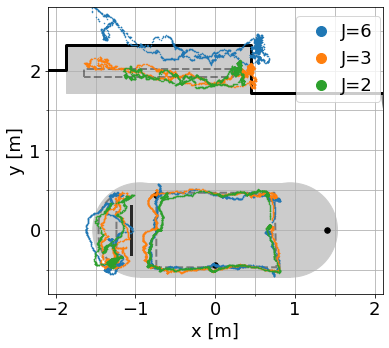

In [19]:
labels = [str(list_diff([1,2,3,4],ss)) for ss in sequence3]
labels = [ll+' $J=6$' for ll in labels[:Nexamples]]
labels += [ll[:-9]+' $J=3$' for ll in labels[:Nexamples]]
labels += [ll[:-9]+' $J=2$' for ll in labels[:Nexamples]]
labels = ['J=6', 'J=3', 'J=2']
opts = {'label':labels, 'ylims':[-.8,2.8],'xlims':[-2.1,2.1]}
show_localization(pp, **opts)
plt.savefig('./fig/'+tag+'_0_affine_{}oo4reg.pdf'.format(3),bbox_inches='tight', pad_inches=0)
plt.show()

### Build and train single layer network

In [20]:
from torch import nn
class SingleLayer(nn.Module):
    def __init__(self, N_in, N_out):
        super(SingleLayer, self).__init__()
        self.linear_stack = nn.Sequential(
            #nn.Linear(N_in, N_in),
            #nn.ReLU(),
            nn.Linear(N_in, N_out),
        )
        
    def forward(self, x):
        return self.linear_stack(x)

In [21]:
def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    mse = 0
    for batch, (X, y) in enumerate(dataloader):
        # Compute prediction and loss
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        mse += loss.item()
        #if batch % 2000 == 0:
            #loss, current = loss.item(), batch * len(X)
            #print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
    return mse
            
def test_loop(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0

    with torch.no_grad():
        for X, y in dataloader:
            pred = model(X)
            test_loss += loss_fn(pred, y).item()

    test_loss /= num_batches
    print(f"Avg loss: {test_loss:>8f}")

In [22]:
singlelayer = SingleLayer(training_data.calib_doa.shape[1],out_dim)

learning_rate = 3e-2
batch_size = 300
epochs = 2000
weight_decay=.0005 #somewhat equal to truncated svd in the linear case
#weight_decay=0 # no regularization
b_truncate_training_data_nn = False

training_data    = MultiarrayDoaDataset(filepath, out_dim, filter_array_idx, points)
train_dataloader = DataLoader(training_data, batch_size = 5, shuffle = True)
if b_truncate_training_data_nn:
    _,_, U,sigma ,VH = generate_linear_transform_matrix(
        training_data.calib_doa.T, 
        training_data.calib_xy[training_data.calib_id].T, 
        trunc = LM_TRUNC) 
    training_data.calib_doa = ((U[:,:LM_TRUNC]@np.diag(sigma[:LM_TRUNC]))@VH[:LM_TRUNC]).T


loss_fn = nn.MSELoss()
optimizer = torch.optim.SGD(singlelayer.parameters(), lr=learning_rate, weight_decay=weight_decay)

Done!


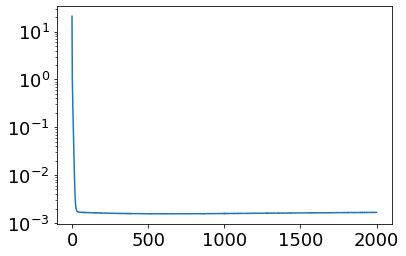

In [23]:
mse = np.zeros(epochs)
for t in range(epochs):
    mse[t] = train_loop(train_dataloader, singlelayer, loss_fn, optimizer)
    # print(f"{t+1}-{mse[t]:3.5f}")
    #test_loop(traintest_dataloader, singlelayer, loss_fn)
print("Done!")
plt.semilogy(mse)

mkdir: ./fig/: File exists
MSE training:  8.225207527478536e-05


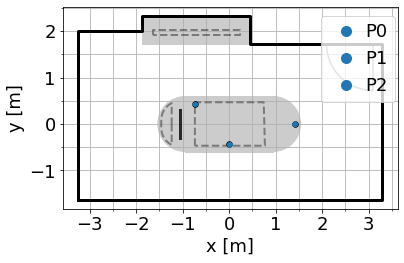

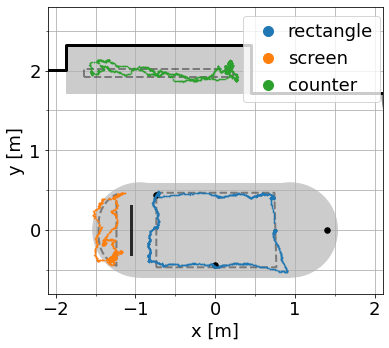

In [24]:
layers = [x.data for x in singlelayer.parameters()]
!mkdir ./fig/

nid = np.unique(training_data.calib_id)
cdlist = [training_data.calib_doa[training_data.calib_id == ii] for ii in nid]
fit = [singlelayer(torch.Tensor(cd)).detach().numpy() for cd in cdlist]
reference = training_data.calib_xy[training_data.calib_id]
print("MSE training: ", np.sum((np.vstack(fit)-reference)**2)/len(reference))
show_localization(fit, 'C0', label = 'single layer training data fit')
plt.savefig('./fig/'+tag+'_1_single_layer_calib.pdf',bbox_inches='tight', pad_inches=0)

predictions = [singlelayer(test_data).detach() for test_data in test_cases]
opts = {'ylims':[-.8,2.8],'xlims':[-2.1,2.1]}
show_localization(predictions, label= 'single layer prediction',**opts)
plt.savefig('./fig/'+tag+'_1_single_layer.pdf',bbox_inches='tight', pad_inches=0)
plt.show()

### parameters of single layer NN vs affine mapping

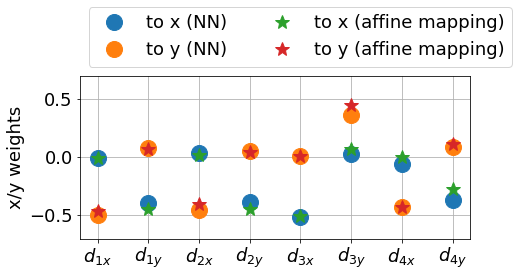

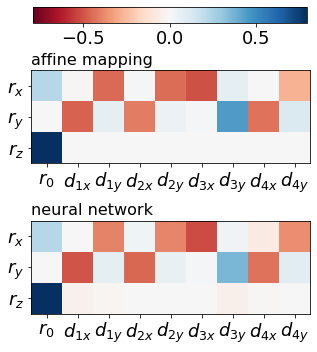

single layer NN biases tensor([ 2.2400e-01, -6.4782e-06,  7.8941e-01])
affine mapping offset R_0) [[ 2.2416677e-01 -1.2471572e-08  7.8999734e-01]]


In [25]:
#print("Model structure: ", singlelayer, "\n\n")
#for name, param in singlelayer.named_parameters():
#    print(f"Layer: {name} | Size: {param.size()} | Values : {param[:2]} \n")
    
if b_divide_by_z:
    idxsort = np.arange(0,2*len(training_data.arrays))
else:
    idxsort = np.arange(0,3*len(training_data.arrays))

plt.figure(figsize=(7,3))
plt.plot(layers[-2][0][idxsort],'o',markersize=16,label='to x (NN)')
plt.plot(layers[-2][1][idxsort],'o',markersize=16,label='to y (NN)')
plt.plot(B[0][idxsort],'*', markersize=14, label='to x (affine mapping)')
plt.plot(B[1][idxsort],'*', markersize=14, label='to y (affine mapping)')
plt.legend(ncol=2, bbox_to_anchor=(0,1),loc='lower left')
plt.grid()
plt.gca().set_xticks(np.arange(2*len(training_data.arrays)))
xticklist = [
    '$d_{1x}$', '$d_{1y}$',
    '$d_{2x}$', '$d_{2y}$',
    '$d_{3x}$', '$d_{3y}$',
    '$d_{4x}$', '$d_{4y}$',
            ]
plt.gca().set_xticklabels(xticklist)
plt.ylabel('x/y weights')
plt.ylim([-.7,.7])
plt.savefig('./fig/'+tag+'_coeffs2.pdf',bbox_inches='tight', pad_inches=0)
plt.show()

fig=plt.figure(figsize=(5,5.5))
nncoeff = np.hstack([layers[-1][:,np.newaxis],layers[-2].numpy()])
afcoeff = np.hstack([R_0,B])
combined = [afcoeff.flatten(),nncoeff.flatten()]
vmax = np.max([-np.min(combined), np.max(combined)])
opts = {'cmap':'RdBu','vmin':-vmax,'vmax':vmax}
for ii in range(1,3):
    plt.subplot(2,1,ii)
    if ii == 1:
        im = plt.imshow(afcoeff,**opts)
        plt.title('affine mapping',fontsize=16,loc='left')
    elif ii == 2:
        im = plt.imshow(nncoeff,**opts)
        plt.title('neural network',fontsize=16,loc='left')
    plt.gca().set_xticks(range(9))
    xticklist = [ '$r_0$',
        '$d_{1x}$', '$d_{1y}$',
        '$d_{2x}$', '$d_{2y}$',
        '$d_{3x}$', '$d_{3y}$',
        '$d_{4x}$', '$d_{4y}$', ]
    plt.gca().set_xticklabels(xticklist)
    plt.gca().set_yticks([0,1,2])
    plt.gca().set_yticklabels(['$r_x$','$r_y$','$r_z$'])
# cbar_ax = fig.add_axes([0.85, 0.19, 0.05, 0.62]) # vertical
# fig.subplots_adjust(bottom=0.15)
# cbar_ax = fig.add_axes([.13,.05,.76,.04]) # below
fig.subplots_adjust(top=.82)
cbar_ax = fig.add_axes([.13,.90,.76,.04]) # above
fig.colorbar(im, cax=cbar_ax,orientation='horizontal')
plt.savefig('./fig/'+tag+'_coeffs.pdf',bbox_inches='tight', pad_inches=0)
plt.show()

print('single layer NN biases', layers[-1])
print('affine mapping offset R_0)', R_0.T)